### DIGITS 64d

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

# Load digits data
digits = load_digits()
X = digits.images
y = digits.target

# Add Gaussian noise with variance 0.01
noise = scs.norm.rvs(0, 0.1, X.shape)
X_noisy = (X + noise)/16 # Normalize to [0, 1]

# Flatten the images for ECDF transformation
X_noisy_flat = X_noisy.reshape(-1, 64)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in range(64):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 8, 8)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)

# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 8, 8)

    output:
        original_example: np.array - the original example, of shape (8, 8)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(8, 8) * 16
    
    return original_example


'''# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8)):
        super(Classifier_Digits, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        return self.model(x).exp()'''

# Define the classifier for digits data (8x8 images)
class Classifier_Digits(nn.Module):
    def __init__(self, in_shape=(1, 8, 8), normalising_cst=True, c=1.0):
        super(Classifier_Digits, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjusted for 8x8 input images
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits
# Define model
model = Classifier_Digits()

# Print model summary
summary(model, (1, 8, 8))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]             640
         LeakyReLU-2             [-1, 64, 4, 4]               0
            Conv2d-3             [-1, 64, 2, 2]          36,928
         LeakyReLU-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
Total params: 37,825
Trainable params: 37,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.14
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [3]:
from tqdm import tqdm
# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 501
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        r_p = model(inputs).squeeze()  
        r_q = model(torch.randn((3*64*inputs.shape[0],1,8,8))).squeeze()      
        loss = loss_nce(r_p, r_q,inputs.shape[0], 10*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


  0%|          | 1/501 [00:04<40:12,  4.82s/it]

Epoch 1/501, Loss: 3.216013456213063


  0%|          | 2/501 [00:09<39:39,  4.77s/it]

Epoch 2/501, Loss: 3.0577625817266005


  1%|          | 3/501 [00:13<36:43,  4.43s/it]

Epoch 3/501, Loss: 2.836865153805963


  1%|          | 4/501 [00:18<37:52,  4.57s/it]

Epoch 4/501, Loss: 2.575634841261239


  1%|          | 5/501 [00:22<37:46,  4.57s/it]

Epoch 5/501, Loss: 2.2492069540352655


  1%|          | 6/501 [00:27<38:01,  4.61s/it]

Epoch 6/501, Loss: 1.9333244685469002


  1%|▏         | 7/501 [00:32<38:57,  4.73s/it]

Epoch 7/501, Loss: 1.6299219337002984


  2%|▏         | 8/501 [00:37<40:21,  4.91s/it]

Epoch 8/501, Loss: 1.3868240693519855


  2%|▏         | 9/501 [00:42<40:03,  4.89s/it]

Epoch 9/501, Loss: 1.1572137433907081


  2%|▏         | 10/501 [00:47<39:18,  4.80s/it]

Epoch 10/501, Loss: 1.0143224144804066


  2%|▏         | 11/501 [00:52<39:09,  4.79s/it]

Epoch 11/501, Loss: 0.8842352525941257


  2%|▏         | 12/501 [00:56<39:14,  4.81s/it]

Epoch 12/501, Loss: 0.7731075297141897


  3%|▎         | 13/501 [01:01<38:02,  4.68s/it]

Epoch 13/501, Loss: 0.6982383645814041


  3%|▎         | 14/501 [01:07<41:49,  5.15s/it]

Epoch 14/501, Loss: 0.6335122785691557


  3%|▎         | 15/501 [01:12<42:06,  5.20s/it]

Epoch 15/501, Loss: 0.5872777443507622


  3%|▎         | 16/501 [01:17<41:18,  5.11s/it]

Epoch 16/501, Loss: 0.5370988270332073


  3%|▎         | 17/501 [01:22<39:54,  4.95s/it]

Epoch 17/501, Loss: 0.5129773277660896


  4%|▎         | 18/501 [01:26<38:08,  4.74s/it]

Epoch 18/501, Loss: 0.4758655685802986


  4%|▍         | 19/501 [01:30<37:04,  4.62s/it]

Epoch 19/501, Loss: 0.4388742570219369


  4%|▍         | 20/501 [01:34<35:00,  4.37s/it]

Epoch 20/501, Loss: 0.4247708022594452


  4%|▍         | 21/501 [01:38<34:39,  4.33s/it]

Epoch 21/501, Loss: 0.38931778998210514


  4%|▍         | 22/501 [01:43<34:11,  4.28s/it]

Epoch 22/501, Loss: 0.4316244978329231


  5%|▍         | 23/501 [01:47<33:14,  4.17s/it]

Epoch 23/501, Loss: 0.3700992989129034


  5%|▍         | 24/501 [01:50<32:09,  4.05s/it]

Epoch 24/501, Loss: 0.3613187989284252


  5%|▍         | 25/501 [01:54<31:37,  3.99s/it]

Epoch 25/501, Loss: 0.331984032844675


  5%|▌         | 26/501 [01:58<31:09,  3.94s/it]

Epoch 26/501, Loss: 0.3127883194849409


  5%|▌         | 27/501 [02:02<30:40,  3.88s/it]

Epoch 27/501, Loss: 0.29962313021051473


  6%|▌         | 28/501 [02:06<30:27,  3.86s/it]

Epoch 28/501, Loss: 0.3010549658331378


  6%|▌         | 29/501 [02:09<30:25,  3.87s/it]

Epoch 29/501, Loss: 0.2899249216605877


  6%|▌         | 30/501 [02:14<31:12,  3.98s/it]

Epoch 30/501, Loss: 0.2741461036534145


  6%|▌         | 31/501 [02:18<30:53,  3.94s/it]

Epoch 31/501, Loss: 0.2623160358132987


  6%|▋         | 32/501 [02:21<30:27,  3.90s/it]

Epoch 32/501, Loss: 0.24797722311883136


  7%|▋         | 33/501 [02:25<29:58,  3.84s/it]

Epoch 33/501, Loss: 0.2479326904847704


  7%|▋         | 34/501 [02:29<29:45,  3.82s/it]

Epoch 34/501, Loss: 0.24940042917070718


  7%|▋         | 35/501 [02:33<29:29,  3.80s/it]

Epoch 35/501, Loss: 0.2321507684115706


  7%|▋         | 36/501 [02:36<29:20,  3.79s/it]

Epoch 36/501, Loss: 0.21718167590683904


  7%|▋         | 37/501 [02:40<29:24,  3.80s/it]

Epoch 37/501, Loss: 0.2171620264135558


  8%|▊         | 38/501 [02:45<30:40,  3.97s/it]

Epoch 38/501, Loss: 0.21466435337888784


  8%|▊         | 39/501 [02:48<30:06,  3.91s/it]

Epoch 39/501, Loss: 0.2026733640452911


  8%|▊         | 40/501 [02:52<29:53,  3.89s/it]

Epoch 40/501, Loss: 0.19614679237891888


  8%|▊         | 41/501 [02:56<29:37,  3.86s/it]

Epoch 41/501, Loss: 0.20051223604843535


  8%|▊         | 42/501 [03:00<29:26,  3.85s/it]

Epoch 42/501, Loss: 0.20163400317060537


  9%|▊         | 43/501 [03:03<29:05,  3.81s/it]

Epoch 43/501, Loss: 0.18615486781144963


  9%|▉         | 44/501 [03:08<29:30,  3.88s/it]

Epoch 44/501, Loss: 0.18363788955170532


  9%|▉         | 45/501 [03:11<29:12,  3.84s/it]

Epoch 45/501, Loss: 0.17482374711283322


  9%|▉         | 46/501 [03:15<29:33,  3.90s/it]

Epoch 46/501, Loss: 0.16994256654690051


  9%|▉         | 47/501 [03:19<30:02,  3.97s/it]

Epoch 47/501, Loss: 0.1619976882276864


 10%|▉         | 48/501 [03:23<29:52,  3.96s/it]

Epoch 48/501, Loss: 0.15777801144225845


 10%|▉         | 49/501 [03:27<29:31,  3.92s/it]

Epoch 49/501, Loss: 0.15720359081852026


 10%|▉         | 50/501 [03:31<29:12,  3.89s/it]

Epoch 50/501, Loss: 0.14940405971017376


 10%|█         | 51/501 [03:35<29:09,  3.89s/it]

Epoch 51/501, Loss: 0.14715939734516473


 10%|█         | 52/501 [03:39<29:04,  3.89s/it]

Epoch 52/501, Loss: 0.1579893182577758


 11%|█         | 53/501 [03:43<28:54,  3.87s/it]

Epoch 53/501, Loss: 0.14741067973704175


 11%|█         | 54/501 [03:46<28:42,  3.85s/it]

Epoch 54/501, Loss: 0.14135859212998686


 11%|█         | 55/501 [03:51<29:36,  3.98s/it]

Epoch 55/501, Loss: 0.14039769409031705


 11%|█         | 56/501 [03:54<28:57,  3.90s/it]

Epoch 56/501, Loss: 0.1328495342669816


 11%|█▏        | 57/501 [03:58<28:34,  3.86s/it]

Epoch 57/501, Loss: 0.12557138631056095


 12%|█▏        | 58/501 [04:02<28:14,  3.83s/it]

Epoch 58/501, Loss: 0.12412572973247232


 12%|█▏        | 59/501 [04:06<28:25,  3.86s/it]

Epoch 59/501, Loss: 0.1255357787013054


 12%|█▏        | 60/501 [04:10<28:06,  3.82s/it]

Epoch 60/501, Loss: 0.13202618781862588


 12%|█▏        | 61/501 [04:13<27:51,  3.80s/it]

Epoch 61/501, Loss: 0.12011580554575756


 12%|█▏        | 62/501 [04:17<27:40,  3.78s/it]

Epoch 62/501, Loss: 0.1168223550093585


 13%|█▎        | 63/501 [04:21<28:10,  3.86s/it]

Epoch 63/501, Loss: 0.1174428506657995


 13%|█▎        | 64/501 [04:25<28:17,  3.88s/it]

Epoch 64/501, Loss: 0.11583335492117651


 13%|█▎        | 65/501 [04:29<28:07,  3.87s/it]

Epoch 65/501, Loss: 0.11356627709906676


 13%|█▎        | 66/501 [04:33<27:48,  3.83s/it]

Epoch 66/501, Loss: 0.12707440349562416


 13%|█▎        | 67/501 [04:37<27:53,  3.86s/it]

Epoch 67/501, Loss: 0.1175771358198133


 14%|█▎        | 68/501 [04:40<27:40,  3.84s/it]

Epoch 68/501, Loss: 0.10822254008260267


 14%|█▍        | 69/501 [04:44<27:38,  3.84s/it]

Epoch 69/501, Loss: 0.10375163999610934


 14%|█▍        | 70/501 [04:48<27:35,  3.84s/it]

Epoch 70/501, Loss: 0.10108484122259863


 14%|█▍        | 71/501 [04:52<27:30,  3.84s/it]

Epoch 71/501, Loss: 0.09772042056609845


 14%|█▍        | 72/501 [04:56<28:04,  3.93s/it]

Epoch 72/501, Loss: 0.09754943179673162


 15%|█▍        | 73/501 [05:00<27:42,  3.88s/it]

Epoch 73/501, Loss: 0.0914324750674182


 15%|█▍        | 74/501 [05:04<27:16,  3.83s/it]

Epoch 74/501, Loss: 0.0912223116591059


 15%|█▍        | 75/501 [05:07<27:10,  3.83s/it]

Epoch 75/501, Loss: 0.09238399141307535


 15%|█▌        | 76/501 [05:11<27:23,  3.87s/it]

Epoch 76/501, Loss: 0.0881030438789006


 15%|█▌        | 77/501 [05:15<27:21,  3.87s/it]

Epoch 77/501, Loss: 0.0857367468034399


 16%|█▌        | 78/501 [05:19<27:14,  3.86s/it]

Epoch 78/501, Loss: 0.08795305893852792


 16%|█▌        | 79/501 [05:23<27:10,  3.86s/it]

Epoch 79/501, Loss: 0.0879683876088981


 16%|█▌        | 80/501 [05:27<28:36,  4.08s/it]

Epoch 80/501, Loss: 0.08710653000864489


 16%|█▌        | 81/501 [05:31<28:14,  4.03s/it]

Epoch 81/501, Loss: 0.08285669346564803


 16%|█▋        | 82/501 [05:35<27:54,  4.00s/it]

Epoch 82/501, Loss: 0.07747036314986903


 17%|█▋        | 83/501 [05:39<27:26,  3.94s/it]

Epoch 83/501, Loss: 0.08438990110981054


 17%|█▋        | 84/501 [05:44<28:18,  4.07s/it]

Epoch 84/501, Loss: 0.08148710725122485


 17%|█▋        | 85/501 [05:48<29:04,  4.19s/it]

Epoch 85/501, Loss: 0.07646542260872907


 17%|█▋        | 86/501 [05:52<28:47,  4.16s/it]

Epoch 86/501, Loss: 0.07342704860814686


 17%|█▋        | 87/501 [05:56<28:56,  4.20s/it]

Epoch 87/501, Loss: 0.07201013919608347


 18%|█▊        | 88/501 [06:01<29:39,  4.31s/it]

Epoch 88/501, Loss: 0.07485621024308534


 18%|█▊        | 89/501 [06:05<29:22,  4.28s/it]

Epoch 89/501, Loss: 0.06986834738275101


 18%|█▊        | 90/501 [06:09<29:09,  4.26s/it]

Epoch 90/501, Loss: 0.06991315209146204


 18%|█▊        | 91/501 [06:13<28:14,  4.13s/it]

Epoch 91/501, Loss: 0.06917080373085778


 18%|█▊        | 92/501 [06:17<27:23,  4.02s/it]

Epoch 92/501, Loss: 0.06984338023025415


 19%|█▊        | 93/501 [06:21<27:03,  3.98s/it]

Epoch 93/501, Loss: 0.06473130424474847


 19%|█▉        | 94/501 [06:25<26:43,  3.94s/it]

Epoch 94/501, Loss: 0.06960272300859978


 19%|█▉        | 95/501 [06:29<27:05,  4.00s/it]

Epoch 95/501, Loss: 0.06749571500153377


 19%|█▉        | 96/501 [06:33<28:10,  4.17s/it]

Epoch 96/501, Loss: 0.06321785110851814


 19%|█▉        | 97/501 [06:38<28:22,  4.21s/it]

Epoch 97/501, Loss: 0.06382245660342019


 20%|█▉        | 98/501 [06:42<28:10,  4.19s/it]

Epoch 98/501, Loss: 0.059905982993800067


 20%|█▉        | 99/501 [06:46<27:41,  4.13s/it]

Epoch 99/501, Loss: 0.059374588092082535


 20%|█▉        | 100/501 [06:50<27:03,  4.05s/it]

Epoch 100/501, Loss: 0.06362953409552574


 20%|██        | 101/501 [06:53<26:24,  3.96s/it]

Epoch 101/501, Loss: 0.06020137789691317


 20%|██        | 102/501 [06:57<26:07,  3.93s/it]

Epoch 102/501, Loss: 0.06329399347305298


 21%|██        | 103/501 [07:01<26:03,  3.93s/it]

Epoch 103/501, Loss: 0.061654374388785196


 21%|██        | 104/501 [07:05<26:28,  4.00s/it]

Epoch 104/501, Loss: 0.05869695878234403


 21%|██        | 105/501 [07:09<26:21,  3.99s/it]

Epoch 105/501, Loss: 0.05477147594351193


 21%|██        | 106/501 [07:13<25:52,  3.93s/it]

Epoch 106/501, Loss: 0.05900385873071078


 21%|██▏       | 107/501 [07:17<25:35,  3.90s/it]

Epoch 107/501, Loss: 0.0592832937836647


 22%|██▏       | 108/501 [07:21<25:16,  3.86s/it]

Epoch 108/501, Loss: 0.05758485031025163


 22%|██▏       | 109/501 [07:25<25:12,  3.86s/it]

Epoch 109/501, Loss: 0.05753249662189648


 22%|██▏       | 110/501 [07:28<24:58,  3.83s/it]

Epoch 110/501, Loss: 0.05378543919530408


 22%|██▏       | 111/501 [07:32<24:44,  3.81s/it]

Epoch 111/501, Loss: 0.05011166285338073


 22%|██▏       | 112/501 [07:36<25:09,  3.88s/it]

Epoch 112/501, Loss: 0.05464321644655589


 23%|██▎       | 113/501 [07:40<25:34,  3.96s/it]

Epoch 113/501, Loss: 0.05275527554853209


 23%|██▎       | 114/501 [07:44<25:19,  3.93s/it]

Epoch 114/501, Loss: 0.053983544866586554


 23%|██▎       | 115/501 [07:48<25:11,  3.92s/it]

Epoch 115/501, Loss: 0.05153154210861901


 23%|██▎       | 116/501 [07:52<25:14,  3.93s/it]

Epoch 116/501, Loss: 0.05189451138521063


 23%|██▎       | 117/501 [07:56<24:59,  3.91s/it]

Epoch 117/501, Loss: 0.04907248162760817


 24%|██▎       | 118/501 [08:00<24:36,  3.86s/it]

Epoch 118/501, Loss: 0.051736274798368585


 24%|██▍       | 119/501 [08:04<24:40,  3.88s/it]

Epoch 119/501, Loss: 0.050152523635790265


 24%|██▍       | 120/501 [08:07<24:29,  3.86s/it]

Epoch 120/501, Loss: 0.05086319623836156


 24%|██▍       | 121/501 [08:12<25:16,  3.99s/it]

Epoch 121/501, Loss: 0.05187014561018039


 24%|██▍       | 122/501 [08:15<24:55,  3.95s/it]

Epoch 122/501, Loss: 0.04463818951927383


 25%|██▍       | 123/501 [08:19<24:40,  3.92s/it]

Epoch 123/501, Loss: 0.04416399731718261


 25%|██▍       | 124/501 [08:23<24:48,  3.95s/it]

Epoch 124/501, Loss: 0.044414588924625825


 25%|██▍       | 125/501 [08:27<24:37,  3.93s/it]

Epoch 125/501, Loss: 0.044146660651112425


 25%|██▌       | 126/501 [08:31<24:21,  3.90s/it]

Epoch 126/501, Loss: 0.04038347975061885


 25%|██▌       | 127/501 [08:35<24:11,  3.88s/it]

Epoch 127/501, Loss: 0.04234147052569636


 26%|██▌       | 128/501 [08:39<24:11,  3.89s/it]

Epoch 128/501, Loss: 0.044645291785227845


 26%|██▌       | 129/501 [08:43<24:57,  4.02s/it]

Epoch 129/501, Loss: 0.03989069693689716


 26%|██▌       | 130/501 [08:47<24:47,  4.01s/it]

Epoch 130/501, Loss: 0.0398100554172335


 26%|██▌       | 131/501 [08:51<24:34,  3.98s/it]

Epoch 131/501, Loss: 0.04068198193121573


 26%|██▋       | 132/501 [08:55<24:14,  3.94s/it]

Epoch 132/501, Loss: 0.038720430083701324


 27%|██▋       | 133/501 [08:59<24:11,  3.94s/it]

Epoch 133/501, Loss: 0.038424662731844805


 27%|██▋       | 134/501 [09:03<23:58,  3.92s/it]

Epoch 134/501, Loss: 0.04107123382132629


 27%|██▋       | 135/501 [09:07<23:43,  3.89s/it]

Epoch 135/501, Loss: 0.03813875656061132


 27%|██▋       | 136/501 [09:10<23:34,  3.88s/it]

Epoch 136/501, Loss: 0.03562964203542676


 27%|██▋       | 137/501 [09:14<23:38,  3.90s/it]

Epoch 137/501, Loss: 0.03519584961107065


 28%|██▊       | 138/501 [09:18<23:58,  3.96s/it]

Epoch 138/501, Loss: 0.039099579098923455


 28%|██▊       | 139/501 [09:22<23:36,  3.91s/it]

Epoch 139/501, Loss: 0.03544672993654064


 28%|██▊       | 140/501 [09:26<23:25,  3.89s/it]

Epoch 140/501, Loss: 0.03387622075187492


 28%|██▊       | 141/501 [09:30<23:15,  3.88s/it]

Epoch 141/501, Loss: 0.038003403243833576


 28%|██▊       | 142/501 [09:34<22:59,  3.84s/it]

Epoch 142/501, Loss: 0.03753163440731065


 29%|██▊       | 143/501 [09:37<22:52,  3.83s/it]

Epoch 143/501, Loss: 0.034509754836045466


 29%|██▊       | 144/501 [09:41<22:51,  3.84s/it]

Epoch 144/501, Loss: 0.0345638208091259


 29%|██▉       | 145/501 [09:45<22:55,  3.86s/it]

Epoch 145/501, Loss: 0.03266095469609417


 29%|██▉       | 146/501 [09:50<23:40,  4.00s/it]

Epoch 146/501, Loss: 0.03477881579049703


 29%|██▉       | 147/501 [09:54<23:34,  4.00s/it]

Epoch 147/501, Loss: 0.03582270000258397


 30%|██▉       | 148/501 [09:57<23:13,  3.95s/it]

Epoch 148/501, Loss: 0.03196082578907753


 30%|██▉       | 149/501 [10:01<22:54,  3.91s/it]

Epoch 149/501, Loss: 0.03284777132473115


 30%|██▉       | 150/501 [10:05<22:36,  3.86s/it]

Epoch 150/501, Loss: 0.03455015519184285


 30%|███       | 151/501 [10:09<22:28,  3.85s/it]

Epoch 151/501, Loss: 0.036592923425908745


 30%|███       | 152/501 [10:13<22:23,  3.85s/it]

Epoch 152/501, Loss: 0.02965596019579419


 31%|███       | 153/501 [10:16<22:13,  3.83s/it]

Epoch 153/501, Loss: 0.03152213643850951


 31%|███       | 154/501 [10:21<22:47,  3.94s/it]

Epoch 154/501, Loss: 0.029830471869429637


 31%|███       | 155/501 [10:24<22:33,  3.91s/it]

Epoch 155/501, Loss: 0.03302245314136661


 31%|███       | 156/501 [10:28<22:19,  3.88s/it]

Epoch 156/501, Loss: 0.034396415961713625


 31%|███▏      | 157/501 [10:32<22:13,  3.88s/it]

Epoch 157/501, Loss: 0.028666656496452874


 32%|███▏      | 158/501 [10:36<22:11,  3.88s/it]

Epoch 158/501, Loss: 0.029642634093761444


 32%|███▏      | 159/501 [10:40<22:04,  3.87s/it]

Epoch 159/501, Loss: 0.029505632496599495


 32%|███▏      | 160/501 [10:44<21:59,  3.87s/it]

Epoch 160/501, Loss: 0.028876161267017496


 32%|███▏      | 161/501 [10:48<22:11,  3.92s/it]

Epoch 161/501, Loss: 0.028435397315128095


 32%|███▏      | 162/501 [10:52<22:22,  3.96s/it]

Epoch 162/501, Loss: 0.02798186538034472


 33%|███▎      | 163/501 [10:56<22:41,  4.03s/it]

Epoch 163/501, Loss: 0.028072931193586052


 33%|███▎      | 164/501 [11:00<22:21,  3.98s/it]

Epoch 164/501, Loss: 0.026090210512408923


 33%|███▎      | 165/501 [11:04<22:12,  3.96s/it]

Epoch 165/501, Loss: 0.027519084416843694


 33%|███▎      | 166/501 [11:08<22:06,  3.96s/it]

Epoch 166/501, Loss: 0.02743168059608032


 33%|███▎      | 167/501 [11:12<21:47,  3.92s/it]

Epoch 167/501, Loss: 0.026419974285466916


 34%|███▎      | 168/501 [11:15<21:33,  3.88s/it]

Epoch 168/501, Loss: 0.02563536341265968


 34%|███▎      | 169/501 [11:19<21:22,  3.86s/it]

Epoch 169/501, Loss: 0.02435264773345713


 34%|███▍      | 170/501 [11:23<21:24,  3.88s/it]

Epoch 170/501, Loss: 0.02626836270993126


 34%|███▍      | 171/501 [11:27<22:01,  4.00s/it]

Epoch 171/501, Loss: 0.027903870454636114


 34%|███▍      | 172/501 [11:31<21:47,  3.97s/it]

Epoch 172/501, Loss: 0.025695888084712726


 35%|███▍      | 173/501 [11:35<21:37,  3.96s/it]

Epoch 173/501, Loss: 0.024890233537760275


 35%|███▍      | 174/501 [11:39<21:28,  3.94s/it]

Epoch 174/501, Loss: 0.025983940360361134


 35%|███▍      | 175/501 [11:43<21:36,  3.98s/it]

Epoch 175/501, Loss: 0.024621051880691587


 35%|███▌      | 176/501 [11:47<21:18,  3.93s/it]

Epoch 176/501, Loss: 0.025176486032533234


 35%|███▌      | 177/501 [11:51<20:58,  3.89s/it]

Epoch 177/501, Loss: 0.025716085564987414


 36%|███▌      | 178/501 [11:55<20:58,  3.90s/it]

Epoch 178/501, Loss: 0.022103205066302728


 36%|███▌      | 179/501 [11:59<21:23,  3.99s/it]

Epoch 179/501, Loss: 0.02228193062935667


 36%|███▌      | 180/501 [12:03<21:12,  3.96s/it]

Epoch 180/501, Loss: 0.023279350668448825


 36%|███▌      | 181/501 [12:07<20:47,  3.90s/it]

Epoch 181/501, Loss: 0.022893269835361118


 36%|███▋      | 182/501 [12:10<20:40,  3.89s/it]

Epoch 182/501, Loss: 0.024695424371045726


 37%|███▋      | 183/501 [12:14<20:49,  3.93s/it]

Epoch 183/501, Loss: 0.027053336291734516


 37%|███▋      | 184/501 [12:18<20:40,  3.91s/it]

Epoch 184/501, Loss: 0.026514552212480842


 37%|███▋      | 185/501 [12:22<20:25,  3.88s/it]

Epoch 185/501, Loss: 0.022296797227242898


 37%|███▋      | 186/501 [12:26<20:27,  3.90s/it]

Epoch 186/501, Loss: 0.02225409178384419


 37%|███▋      | 187/501 [12:30<20:43,  3.96s/it]

Epoch 187/501, Loss: 0.02027783057941445


 38%|███▊      | 188/501 [12:34<20:36,  3.95s/it]

Epoch 188/501, Loss: 0.019836891988485025


 38%|███▊      | 189/501 [12:38<20:25,  3.93s/it]

Epoch 189/501, Loss: 0.0216273355843692


 38%|███▊      | 190/501 [12:42<20:20,  3.92s/it]

Epoch 190/501, Loss: 0.019396557966407775


 38%|███▊      | 191/501 [12:46<20:14,  3.92s/it]

Epoch 191/501, Loss: 0.02040029341226508


 38%|███▊      | 192/501 [12:50<20:05,  3.90s/it]

Epoch 192/501, Loss: 0.023066944988637136


 39%|███▊      | 193/501 [12:54<19:58,  3.89s/it]

Epoch 193/501, Loss: 0.021055232283884083


 39%|███▊      | 194/501 [12:57<19:56,  3.90s/it]

Epoch 194/501, Loss: 0.020543088558418996


 39%|███▉      | 195/501 [13:01<19:47,  3.88s/it]

Epoch 195/501, Loss: 0.018989048769761777


 39%|███▉      | 196/501 [13:06<20:33,  4.04s/it]

Epoch 196/501, Loss: 0.02232477964897608


 39%|███▉      | 197/501 [13:10<20:28,  4.04s/it]

Epoch 197/501, Loss: 0.02032490119594952


 40%|███▉      | 198/501 [13:14<20:05,  3.98s/it]

Epoch 198/501, Loss: 0.020342893159851945


 40%|███▉      | 199/501 [13:17<19:44,  3.92s/it]

Epoch 199/501, Loss: 0.02091125273627454


 40%|███▉      | 200/501 [13:21<19:30,  3.89s/it]

Epoch 200/501, Loss: 0.018946737580900562


 40%|████      | 201/501 [13:25<19:20,  3.87s/it]

Epoch 201/501, Loss: 0.018442619497614818


 40%|████      | 202/501 [13:29<19:12,  3.86s/it]

Epoch 202/501, Loss: 0.018439323866161806


 41%|████      | 203/501 [13:33<19:10,  3.86s/it]

Epoch 203/501, Loss: 0.020046132680927885


 41%|████      | 204/501 [13:37<19:41,  3.98s/it]

Epoch 204/501, Loss: 0.020938489277012133


 41%|████      | 205/501 [13:41<19:23,  3.93s/it]

Epoch 205/501, Loss: 0.016919837718636824


 41%|████      | 206/501 [13:45<19:18,  3.93s/it]

Epoch 206/501, Loss: 0.01689269210629422


 41%|████▏     | 207/501 [13:49<19:08,  3.90s/it]

Epoch 207/501, Loss: 0.016180852299620366


 42%|████▏     | 208/501 [13:52<18:54,  3.87s/it]

Epoch 208/501, Loss: 0.017232414752501864


 42%|████▏     | 209/501 [13:56<18:56,  3.89s/it]

Epoch 209/501, Loss: 0.017800338742933398


 42%|████▏     | 210/501 [14:00<18:58,  3.91s/it]

Epoch 210/501, Loss: 0.017572446985186303


 42%|████▏     | 211/501 [14:05<19:38,  4.06s/it]

Epoch 211/501, Loss: 0.017128312510663067


 42%|████▏     | 212/501 [14:09<20:05,  4.17s/it]

Epoch 212/501, Loss: 0.01723171622845633


 43%|████▎     | 213/501 [14:13<20:14,  4.22s/it]

Epoch 213/501, Loss: 0.017703542927408528


 43%|████▎     | 214/501 [14:18<20:02,  4.19s/it]

Epoch 214/501, Loss: 0.017739177970536823


 43%|████▎     | 215/501 [14:22<19:38,  4.12s/it]

Epoch 215/501, Loss: 0.01885476548642177


 43%|████▎     | 216/501 [14:25<19:11,  4.04s/it]

Epoch 216/501, Loss: 0.017392946856802906


 43%|████▎     | 217/501 [14:29<18:48,  3.97s/it]

Epoch 217/501, Loss: 0.016542382506204063


 44%|████▎     | 218/501 [14:33<18:33,  3.93s/it]

Epoch 218/501, Loss: 0.014796209132202483


 44%|████▎     | 219/501 [14:37<18:23,  3.91s/it]

Epoch 219/501, Loss: 0.015549186504735002


 44%|████▍     | 220/501 [14:41<18:29,  3.95s/it]

Epoch 220/501, Loss: 0.017548247304712904


 44%|████▍     | 221/501 [14:45<18:40,  4.00s/it]

Epoch 221/501, Loss: 0.014414514045648533


 44%|████▍     | 222/501 [14:49<18:25,  3.96s/it]

Epoch 222/501, Loss: 0.015123139874174678


 45%|████▍     | 223/501 [14:53<18:22,  3.97s/it]

Epoch 223/501, Loss: 0.014818321592335043


 45%|████▍     | 224/501 [14:57<18:09,  3.93s/it]

Epoch 224/501, Loss: 0.01380735587585589


 45%|████▍     | 225/501 [15:00<17:49,  3.87s/it]

Epoch 225/501, Loss: 0.015274867334389047


 45%|████▌     | 226/501 [15:04<17:42,  3.86s/it]

Epoch 226/501, Loss: 0.015351018065522457


 45%|████▌     | 227/501 [15:08<17:30,  3.83s/it]

Epoch 227/501, Loss: 0.013356517245671872


 46%|████▌     | 228/501 [15:12<17:25,  3.83s/it]

Epoch 228/501, Loss: 0.015101221181323817


 46%|████▌     | 229/501 [15:16<18:02,  3.98s/it]

Epoch 229/501, Loss: 0.015336818800404155


 46%|████▌     | 230/501 [15:20<17:52,  3.96s/it]

Epoch 230/501, Loss: 0.014647151684741778


 46%|████▌     | 231/501 [15:24<17:32,  3.90s/it]

Epoch 231/501, Loss: 0.013147899672260573


 46%|████▋     | 232/501 [15:28<17:41,  3.95s/it]

Epoch 232/501, Loss: 0.01354395546789827


 47%|████▋     | 233/501 [15:32<17:28,  3.91s/it]

Epoch 233/501, Loss: 0.014664304314245438


 47%|████▋     | 234/501 [15:36<17:27,  3.92s/it]

Epoch 234/501, Loss: 0.01516336589602047


 47%|████▋     | 235/501 [15:40<17:10,  3.87s/it]

Epoch 235/501, Loss: 0.013082572018149597


 47%|████▋     | 236/501 [15:44<17:17,  3.91s/it]

Epoch 236/501, Loss: 0.014094807083140416


 47%|████▋     | 237/501 [15:48<17:45,  4.04s/it]

Epoch 237/501, Loss: 0.013827663974772239


 48%|████▊     | 238/501 [15:52<17:30,  3.99s/it]

Epoch 238/501, Loss: 0.01304092662858552


 48%|████▊     | 239/501 [15:56<17:29,  4.01s/it]

Epoch 239/501, Loss: 0.011532713795594614


 48%|████▊     | 240/501 [16:00<17:14,  3.96s/it]

Epoch 240/501, Loss: 0.011227823338262609


 48%|████▊     | 241/501 [16:04<17:05,  3.94s/it]

Epoch 241/501, Loss: 0.013151418493964291


 48%|████▊     | 242/501 [16:07<16:59,  3.93s/it]

Epoch 242/501, Loss: 0.01369800318056589


 49%|████▊     | 243/501 [16:12<17:39,  4.11s/it]

Epoch 243/501, Loss: 0.013320099417890969


 49%|████▊     | 244/501 [16:16<17:54,  4.18s/it]

Epoch 244/501, Loss: 0.015682026519086855


 49%|████▉     | 245/501 [16:21<18:11,  4.26s/it]

Epoch 245/501, Loss: 0.013886235156578237


 49%|████▉     | 246/501 [16:25<17:59,  4.23s/it]

Epoch 246/501, Loss: 0.014892868424669421


 49%|████▉     | 247/501 [16:29<17:39,  4.17s/it]

Epoch 247/501, Loss: 0.01223483871154744


 50%|████▉     | 248/501 [16:33<17:17,  4.10s/it]

Epoch 248/501, Loss: 0.013631452509234178


 50%|████▉     | 249/501 [16:37<17:10,  4.09s/it]

Epoch 249/501, Loss: 0.012711151218009663


 50%|████▉     | 250/501 [16:41<16:50,  4.02s/it]

Epoch 250/501, Loss: 0.010862005713941723


 50%|█████     | 251/501 [16:45<16:37,  3.99s/it]

Epoch 251/501, Loss: 0.013239104453281596


 50%|█████     | 252/501 [16:49<16:31,  3.98s/it]

Epoch 252/501, Loss: 0.010378128736568936


 50%|█████     | 253/501 [16:53<16:54,  4.09s/it]

Epoch 253/501, Loss: 0.012651016213128278


 51%|█████     | 254/501 [16:57<17:02,  4.14s/it]

Epoch 254/501, Loss: 0.012228211131075332


 51%|█████     | 255/501 [17:01<16:45,  4.09s/it]

Epoch 255/501, Loss: 0.010604046837121633


 51%|█████     | 256/501 [17:05<16:26,  4.03s/it]

Epoch 256/501, Loss: 0.011836978328887951


 51%|█████▏    | 257/501 [17:09<16:09,  3.97s/it]

Epoch 257/501, Loss: 0.012147914943413744


 51%|█████▏    | 258/501 [17:13<15:55,  3.93s/it]

Epoch 258/501, Loss: 0.010440897517677012


 52%|█████▏    | 259/501 [17:17<15:48,  3.92s/it]

Epoch 259/501, Loss: 0.011987542657277965


 52%|█████▏    | 260/501 [17:21<15:36,  3.89s/it]

Epoch 260/501, Loss: 0.011475939544495838


 52%|█████▏    | 261/501 [17:25<16:00,  4.00s/it]

Epoch 261/501, Loss: 0.010395137065266869


 52%|█████▏    | 262/501 [17:29<15:56,  4.00s/it]

Epoch 262/501, Loss: 0.010067271429981137


 52%|█████▏    | 263/501 [17:33<15:37,  3.94s/it]

Epoch 263/501, Loss: 0.00966021971945683


 53%|█████▎    | 264/501 [17:36<15:23,  3.90s/it]

Epoch 264/501, Loss: 0.009414935311912719


 53%|█████▎    | 265/501 [17:40<15:19,  3.89s/it]

Epoch 265/501, Loss: 0.011328035859182349


 53%|█████▎    | 266/501 [17:44<15:35,  3.98s/it]

Epoch 266/501, Loss: 0.009031492044571144


 53%|█████▎    | 267/501 [17:48<15:25,  3.96s/it]

Epoch 267/501, Loss: 0.01057002570777168


 53%|█████▎    | 268/501 [17:52<15:13,  3.92s/it]

Epoch 268/501, Loss: 0.010263280356945148


 54%|█████▎    | 269/501 [17:56<15:14,  3.94s/it]

Epoch 269/501, Loss: 0.009940380539648748


 54%|█████▍    | 270/501 [18:00<15:33,  4.04s/it]

Epoch 270/501, Loss: 0.01099567328868755


 54%|█████▍    | 271/501 [18:04<15:15,  3.98s/it]

Epoch 271/501, Loss: 0.008759451660745102


 54%|█████▍    | 272/501 [18:08<15:03,  3.95s/it]

Epoch 272/501, Loss: 0.009897273812635705


 54%|█████▍    | 273/501 [18:12<14:47,  3.89s/it]

Epoch 273/501, Loss: 0.00918098885951371


 55%|█████▍    | 274/501 [18:16<14:56,  3.95s/it]

Epoch 274/501, Loss: 0.009012557269106138


 55%|█████▍    | 275/501 [18:20<14:46,  3.92s/it]

Epoch 275/501, Loss: 0.010497605793402883


 55%|█████▌    | 276/501 [18:24<14:35,  3.89s/it]

Epoch 276/501, Loss: 0.009597354552483764


 55%|█████▌    | 277/501 [18:28<14:26,  3.87s/it]

Epoch 277/501, Loss: 0.009675153916508987


 55%|█████▌    | 278/501 [18:32<14:45,  3.97s/it]

Epoch 278/501, Loss: 0.009527965360481677


 56%|█████▌    | 279/501 [18:36<14:37,  3.95s/it]

Epoch 279/501, Loss: 0.008190077958339504


 56%|█████▌    | 280/501 [18:39<14:25,  3.91s/it]

Epoch 280/501, Loss: 0.010748084281282178


 56%|█████▌    | 281/501 [18:43<14:18,  3.90s/it]

Epoch 281/501, Loss: 0.009030368612629586


 56%|█████▋    | 282/501 [18:47<14:15,  3.91s/it]

Epoch 282/501, Loss: 0.009547654507232124


 56%|█████▋    | 283/501 [18:51<14:15,  3.92s/it]

Epoch 283/501, Loss: 0.009603530319070379


 57%|█████▋    | 284/501 [18:55<14:07,  3.91s/it]

Epoch 284/501, Loss: 0.008738593174273083


 57%|█████▋    | 285/501 [18:59<14:02,  3.90s/it]

Epoch 285/501, Loss: 0.01408815147869032


 57%|█████▋    | 286/501 [19:03<14:25,  4.03s/it]

Epoch 286/501, Loss: 0.009553489270007863


 57%|█████▋    | 287/501 [19:07<14:18,  4.01s/it]

Epoch 287/501, Loss: 0.009442767569923708


 57%|█████▋    | 288/501 [19:11<14:06,  3.97s/it]

Epoch 288/501, Loss: 0.00829179651617747


 58%|█████▊    | 289/501 [19:15<13:55,  3.94s/it]

Epoch 289/501, Loss: 0.008777877091076868


 58%|█████▊    | 290/501 [19:19<13:44,  3.91s/it]

Epoch 290/501, Loss: 0.01113536376666663


 58%|█████▊    | 291/501 [19:23<13:41,  3.91s/it]

Epoch 291/501, Loss: 0.00879271052063218


 58%|█████▊    | 292/501 [19:27<13:45,  3.95s/it]

Epoch 292/501, Loss: 0.007914158208536562


 58%|█████▊    | 293/501 [19:31<13:30,  3.90s/it]

Epoch 293/501, Loss: 0.011597778206562688


 59%|█████▊    | 294/501 [19:35<13:36,  3.94s/it]

Epoch 294/501, Loss: 0.011331943048421165


 59%|█████▉    | 295/501 [19:39<13:45,  4.01s/it]

Epoch 295/501, Loss: 0.008753278146192816


 59%|█████▉    | 296/501 [19:43<13:32,  3.96s/it]

Epoch 296/501, Loss: 0.007970964889331111


 59%|█████▉    | 297/501 [19:47<13:24,  3.94s/it]

Epoch 297/501, Loss: 0.008188302070705285


 59%|█████▉    | 298/501 [19:50<13:12,  3.90s/it]

Epoch 298/501, Loss: 0.008294092860586685


 60%|█████▉    | 299/501 [19:54<13:04,  3.88s/it]

Epoch 299/501, Loss: 0.008661081307920915


 60%|█████▉    | 300/501 [19:58<13:04,  3.90s/it]

Epoch 300/501, Loss: 0.00801339735887174


 60%|██████    | 301/501 [20:02<13:11,  3.96s/it]

Epoch 301/501, Loss: 0.007448778058209553


 60%|██████    | 302/501 [20:06<13:04,  3.94s/it]

Epoch 302/501, Loss: 0.007821603417235973


 60%|██████    | 303/501 [20:11<13:27,  4.08s/it]

Epoch 303/501, Loss: 0.007999970573642901


 61%|██████    | 304/501 [20:14<13:11,  4.02s/it]

Epoch 304/501, Loss: 0.007442870490445659


 61%|██████    | 305/501 [20:18<13:11,  4.04s/it]

Epoch 305/501, Loss: 0.008506232061712393


 61%|██████    | 306/501 [20:23<13:06,  4.03s/it]

Epoch 306/501, Loss: 0.006751355562551782


 61%|██████▏   | 307/501 [20:26<12:55,  4.00s/it]

Epoch 307/501, Loss: 0.006988245068551523


 61%|██████▏   | 308/501 [20:30<12:43,  3.96s/it]

Epoch 308/501, Loss: 0.007389243427214438


 62%|██████▏   | 309/501 [20:34<12:41,  3.96s/it]

Epoch 309/501, Loss: 0.007406648657894854


 62%|██████▏   | 310/501 [20:38<12:29,  3.92s/it]

Epoch 310/501, Loss: 0.007303449172719285


 62%|██████▏   | 311/501 [20:42<12:47,  4.04s/it]

Epoch 311/501, Loss: 0.008960720280121112


 62%|██████▏   | 312/501 [20:46<12:36,  4.00s/it]

Epoch 312/501, Loss: 0.007489573904955438


 62%|██████▏   | 313/501 [20:50<12:25,  3.96s/it]

Epoch 313/501, Loss: 0.008545057763795143


 63%|██████▎   | 314/501 [20:55<12:45,  4.10s/it]

Epoch 314/501, Loss: 0.012452574936544588


 63%|██████▎   | 315/501 [20:59<12:41,  4.10s/it]

Epoch 315/501, Loss: 0.011225276193099803


 63%|██████▎   | 316/501 [21:03<12:39,  4.11s/it]

Epoch 316/501, Loss: 0.006777843516641136


 63%|██████▎   | 317/501 [21:07<12:48,  4.18s/it]

Epoch 317/501, Loss: 0.008947477836547226


 63%|██████▎   | 318/501 [21:11<12:35,  4.13s/it]

Epoch 318/501, Loss: 0.007562695511171177


 64%|██████▎   | 319/501 [21:16<12:51,  4.24s/it]

Epoch 319/501, Loss: 0.007055434542868672


 64%|██████▍   | 320/501 [21:20<12:29,  4.14s/it]

Epoch 320/501, Loss: 0.00764163743287068


 64%|██████▍   | 321/501 [21:23<12:04,  4.03s/it]

Epoch 321/501, Loss: 0.007264401916221812


 64%|██████▍   | 322/501 [21:27<11:56,  4.00s/it]

Epoch 322/501, Loss: 0.006537855715201846


 64%|██████▍   | 323/501 [21:31<11:53,  4.01s/it]

Epoch 323/501, Loss: 0.006717507497624269


 65%|██████▍   | 324/501 [21:35<11:53,  4.03s/it]

Epoch 324/501, Loss: 0.007163878144889042


 65%|██████▍   | 325/501 [21:39<11:46,  4.01s/it]

Epoch 325/501, Loss: 0.006503365219345894


 65%|██████▌   | 326/501 [21:43<11:46,  4.04s/it]

Epoch 326/501, Loss: 0.00801179567472367


 65%|██████▌   | 327/501 [21:48<11:51,  4.09s/it]

Epoch 327/501, Loss: 0.006617696835370413


 65%|██████▌   | 328/501 [21:52<11:35,  4.02s/it]

Epoch 328/501, Loss: 0.007204796785713527


 66%|██████▌   | 329/501 [21:55<11:22,  3.97s/it]

Epoch 329/501, Loss: 0.0079268342895626


 66%|██████▌   | 330/501 [21:59<11:12,  3.93s/it]

Epoch 330/501, Loss: 0.006536074544720608


 66%|██████▌   | 331/501 [22:03<11:02,  3.90s/it]

Epoch 331/501, Loss: 0.00695906375316052


 66%|██████▋   | 332/501 [22:07<10:50,  3.85s/it]

Epoch 332/501, Loss: 0.007128175777575836


 66%|██████▋   | 333/501 [22:11<11:01,  3.94s/it]

Epoch 333/501, Loss: 0.0063084085032359925


 67%|██████▋   | 334/501 [22:16<11:38,  4.18s/it]

Epoch 334/501, Loss: 0.005895160759070583


 67%|██████▋   | 335/501 [22:21<12:10,  4.40s/it]

Epoch 335/501, Loss: 0.006789639062280285


 67%|██████▋   | 336/501 [22:25<12:17,  4.47s/it]

Epoch 336/501, Loss: 0.010123572561183366


 67%|██████▋   | 337/501 [22:30<12:07,  4.43s/it]

Epoch 337/501, Loss: 0.007338945320325679


 67%|██████▋   | 338/501 [22:34<11:48,  4.35s/it]

Epoch 338/501, Loss: 0.0060824905361594826


 68%|██████▊   | 339/501 [22:38<11:38,  4.31s/it]

Epoch 339/501, Loss: 0.006091278046369553


 68%|██████▊   | 340/501 [22:42<11:15,  4.19s/it]

Epoch 340/501, Loss: 0.007417092619640431


 68%|██████▊   | 341/501 [22:46<11:01,  4.13s/it]

Epoch 341/501, Loss: 0.005862816823004135


 68%|██████▊   | 342/501 [22:50<10:52,  4.10s/it]

Epoch 342/501, Loss: 0.0051449191363143


 68%|██████▊   | 343/501 [22:54<10:55,  4.15s/it]

Epoch 343/501, Loss: 0.005497577588734015


 69%|██████▊   | 344/501 [22:58<10:44,  4.11s/it]

Epoch 344/501, Loss: 0.005666130977072592


 69%|██████▉   | 345/501 [23:02<10:26,  4.02s/it]

Epoch 345/501, Loss: 0.0049250326801797955


 69%|██████▉   | 346/501 [23:06<10:30,  4.07s/it]

Epoch 346/501, Loss: 0.0063329217925362676


 69%|██████▉   | 347/501 [23:10<10:24,  4.06s/it]

Epoch 347/501, Loss: 0.005286368340703434


 69%|██████▉   | 348/501 [23:14<10:09,  3.98s/it]

Epoch 348/501, Loss: 0.0052420505440938445


 70%|██████▉   | 349/501 [23:18<09:59,  3.94s/it]

Epoch 349/501, Loss: 0.005305935837456892


 70%|██████▉   | 350/501 [23:22<09:50,  3.91s/it]

Epoch 350/501, Loss: 0.004874521114006398


 70%|███████   | 351/501 [23:26<10:13,  4.09s/it]

Epoch 351/501, Loss: 0.0047599085333660755


 70%|███████   | 352/501 [23:30<10:03,  4.05s/it]

Epoch 352/501, Loss: 0.00569695999428373


 70%|███████   | 353/501 [23:34<09:55,  4.02s/it]

Epoch 353/501, Loss: 0.005992095568217337


 71%|███████   | 354/501 [23:38<09:44,  3.97s/it]

Epoch 354/501, Loss: 0.005559086215537812


 71%|███████   | 355/501 [23:42<09:33,  3.93s/it]

Epoch 355/501, Loss: 0.0077307573840792836


 71%|███████   | 356/501 [23:46<09:26,  3.91s/it]

Epoch 356/501, Loss: 0.005949295454574267


 71%|███████▏  | 357/501 [23:49<09:19,  3.88s/it]

Epoch 357/501, Loss: 0.006827523827488567


 71%|███████▏  | 358/501 [23:53<09:12,  3.87s/it]

Epoch 358/501, Loss: 0.004869681309581461


 72%|███████▏  | 359/501 [23:58<09:29,  4.01s/it]

Epoch 359/501, Loss: 0.0061975896402647526


 72%|███████▏  | 360/501 [24:02<09:21,  3.98s/it]

Epoch 360/501, Loss: 0.006201096115922877


 72%|███████▏  | 361/501 [24:05<09:12,  3.94s/it]

Epoch 361/501, Loss: 0.005969629812672542


 72%|███████▏  | 362/501 [24:09<09:02,  3.90s/it]

Epoch 362/501, Loss: 0.005713430331650607


 72%|███████▏  | 363/501 [24:13<09:04,  3.95s/it]

Epoch 363/501, Loss: 0.005472251462974939


 73%|███████▎  | 364/501 [24:17<08:58,  3.93s/it]

Epoch 364/501, Loss: 0.004886514611606454


 73%|███████▎  | 365/501 [24:21<08:50,  3.90s/it]

Epoch 365/501, Loss: 0.005569538374527775


 73%|███████▎  | 366/501 [24:25<08:43,  3.88s/it]

Epoch 366/501, Loss: 0.004400906640763298


 73%|███████▎  | 367/501 [24:29<08:44,  3.91s/it]

Epoch 367/501, Loss: 0.005117140951213138


 73%|███████▎  | 368/501 [24:33<08:52,  4.00s/it]

Epoch 368/501, Loss: 0.0038719015308366768


 74%|███████▎  | 369/501 [24:37<08:41,  3.95s/it]

Epoch 369/501, Loss: 0.005910571668586084


 74%|███████▍  | 370/501 [24:41<08:32,  3.91s/it]

Epoch 370/501, Loss: 0.006224632909489346


 74%|███████▍  | 371/501 [24:45<08:29,  3.92s/it]

Epoch 371/501, Loss: 0.006261410850003876


 74%|███████▍  | 372/501 [24:48<08:21,  3.89s/it]

Epoch 372/501, Loss: 0.004384627071980001


 74%|███████▍  | 373/501 [24:52<08:16,  3.88s/it]

Epoch 373/501, Loss: 0.005423503998137112


 75%|███████▍  | 374/501 [24:56<08:12,  3.88s/it]

Epoch 374/501, Loss: 0.005091538110844277


 75%|███████▍  | 375/501 [25:00<08:14,  3.92s/it]

Epoch 375/501, Loss: 0.004437733281018405


 75%|███████▌  | 376/501 [25:04<08:20,  4.00s/it]

Epoch 376/501, Loss: 0.00525638324575868


 75%|███████▌  | 377/501 [25:08<08:13,  3.98s/it]

Epoch 377/501, Loss: 0.005088540389712354


 75%|███████▌  | 378/501 [25:12<08:04,  3.94s/it]

Epoch 378/501, Loss: 0.005112883032717067


 76%|███████▌  | 379/501 [25:16<07:54,  3.89s/it]

Epoch 379/501, Loss: 0.0060038345962249


 76%|███████▌  | 380/501 [25:20<07:48,  3.87s/it]

Epoch 380/501, Loss: 0.004447342482684502


 76%|███████▌  | 381/501 [25:24<07:43,  3.86s/it]

Epoch 381/501, Loss: 0.004087068650325568


 76%|███████▌  | 382/501 [25:27<07:39,  3.86s/it]

Epoch 382/501, Loss: 0.005288992562845093


 76%|███████▋  | 383/501 [25:31<07:36,  3.87s/it]

Epoch 383/501, Loss: 0.007227227276448032


 77%|███████▋  | 384/501 [25:35<07:42,  3.96s/it]

Epoch 384/501, Loss: 0.00455146161478077


 77%|███████▋  | 385/501 [25:39<07:35,  3.93s/it]

Epoch 385/501, Loss: 0.005152724113251115


 77%|███████▋  | 386/501 [25:43<07:30,  3.92s/it]

Epoch 386/501, Loss: 0.005541590002269067


 77%|███████▋  | 387/501 [25:47<07:30,  3.95s/it]

Epoch 387/501, Loss: 0.0038252569582505986


 77%|███████▋  | 388/501 [25:51<07:23,  3.92s/it]

Epoch 388/501, Loss: 0.004536724536968717


 78%|███████▊  | 389/501 [25:55<07:16,  3.90s/it]

Epoch 389/501, Loss: 0.005344876910636105


 78%|███████▊  | 390/501 [25:59<07:20,  3.97s/it]

Epoch 390/501, Loss: 0.004332257502969226


 78%|███████▊  | 391/501 [26:03<07:11,  3.92s/it]

Epoch 391/501, Loss: 0.004649001535026714


 78%|███████▊  | 392/501 [26:07<07:17,  4.02s/it]

Epoch 392/501, Loss: 0.003533313388069128


 78%|███████▊  | 393/501 [26:11<07:23,  4.10s/it]

Epoch 393/501, Loss: 0.0050393997747772215


 79%|███████▊  | 394/501 [26:16<07:18,  4.09s/it]

Epoch 394/501, Loss: 0.0038521128128571757


 79%|███████▉  | 395/501 [26:19<07:08,  4.05s/it]

Epoch 395/501, Loss: 0.004441031270885262


 79%|███████▉  | 396/501 [26:23<06:59,  3.99s/it]

Epoch 396/501, Loss: 0.00447387887959786


 79%|███████▉  | 397/501 [26:27<06:50,  3.94s/it]

Epoch 397/501, Loss: 0.0035355308994220306


 79%|███████▉  | 398/501 [26:31<06:46,  3.94s/it]

Epoch 398/501, Loss: 0.004837452353716925


 80%|███████▉  | 399/501 [26:35<06:46,  3.98s/it]

Epoch 399/501, Loss: 0.005452634080248917


 80%|███████▉  | 400/501 [26:39<06:40,  3.97s/it]

Epoch 400/501, Loss: 0.004046656371993494


 80%|████████  | 401/501 [26:43<06:44,  4.04s/it]

Epoch 401/501, Loss: 0.004245753825545825


 80%|████████  | 402/501 [26:47<06:37,  4.01s/it]

Epoch 402/501, Loss: 0.004931488597980331


 80%|████████  | 403/501 [26:51<06:29,  3.97s/it]

Epoch 403/501, Loss: 0.003743789048367662


 81%|████████  | 404/501 [26:55<06:22,  3.95s/it]

Epoch 404/501, Loss: 0.004915372291900988


 81%|████████  | 405/501 [26:59<06:21,  3.97s/it]

Epoch 405/501, Loss: 0.00503303906476378


 81%|████████  | 406/501 [27:03<06:13,  3.93s/it]

Epoch 406/501, Loss: 0.004806570841224286


 81%|████████  | 407/501 [27:07<06:08,  3.92s/it]

Epoch 407/501, Loss: 0.00399364565563356


 81%|████████▏ | 408/501 [27:11<06:01,  3.89s/it]

Epoch 408/501, Loss: 0.0033884418923568367


 82%|████████▏ | 409/501 [27:15<06:09,  4.02s/it]

Epoch 409/501, Loss: 0.004459372452339298


 82%|████████▏ | 410/501 [27:19<06:02,  3.98s/it]

Epoch 410/501, Loss: 0.0044642397812728225


 82%|████████▏ | 411/501 [27:23<05:53,  3.93s/it]

Epoch 411/501, Loss: 0.003668481815237038


 82%|████████▏ | 412/501 [27:26<05:46,  3.90s/it]

Epoch 412/501, Loss: 0.0029313866207616984


 82%|████████▏ | 413/501 [27:30<05:43,  3.90s/it]

Epoch 413/501, Loss: 0.004764914028908543


 83%|████████▎ | 414/501 [27:34<05:37,  3.88s/it]

Epoch 414/501, Loss: 0.00497605310073564


 83%|████████▎ | 415/501 [27:38<05:32,  3.87s/it]

Epoch 415/501, Loss: 0.005285595214508217


 83%|████████▎ | 416/501 [27:42<05:28,  3.86s/it]

Epoch 416/501, Loss: 0.003924717876167239


 83%|████████▎ | 417/501 [27:46<05:40,  4.05s/it]

Epoch 417/501, Loss: 0.0038833276746023833


 83%|████████▎ | 418/501 [27:50<05:35,  4.05s/it]

Epoch 418/501, Loss: 0.003912994276796435


 84%|████████▎ | 419/501 [27:54<05:26,  3.98s/it]

Epoch 419/501, Loss: 0.004268392755906901


 84%|████████▍ | 420/501 [27:58<05:19,  3.94s/it]

Epoch 420/501, Loss: 0.003432838071603328


 84%|████████▍ | 421/501 [28:02<05:14,  3.93s/it]

Epoch 421/501, Loss: 0.004654505215826091


 84%|████████▍ | 422/501 [28:06<05:08,  3.91s/it]

Epoch 422/501, Loss: 0.0031635282452796296


 84%|████████▍ | 423/501 [28:10<05:01,  3.87s/it]

Epoch 423/501, Loss: 0.004003728483000706


 85%|████████▍ | 424/501 [28:14<05:01,  3.92s/it]

Epoch 424/501, Loss: 0.004287768262154964


 85%|████████▍ | 425/501 [28:18<05:01,  3.96s/it]

Epoch 425/501, Loss: 0.004268725045378609


 85%|████████▌ | 426/501 [28:22<04:58,  3.98s/it]

Epoch 426/501, Loss: 0.003108787202453923


 85%|████████▌ | 427/501 [28:25<04:49,  3.91s/it]

Epoch 427/501, Loss: 0.0032511326737284406


 85%|████████▌ | 428/501 [28:29<04:46,  3.92s/it]

Epoch 428/501, Loss: 0.0035283808949692495


 86%|████████▌ | 429/501 [28:33<04:40,  3.89s/it]

Epoch 429/501, Loss: 0.00421126251277546


 86%|████████▌ | 430/501 [28:37<04:40,  3.95s/it]

Epoch 430/501, Loss: 0.004682245166522676


 86%|████████▌ | 431/501 [28:41<04:34,  3.92s/it]

Epoch 431/501, Loss: 0.004218186296415736


 86%|████████▌ | 432/501 [28:45<04:30,  3.92s/it]

Epoch 432/501, Loss: 0.0034066391285862132


 86%|████████▋ | 433/501 [28:49<04:28,  3.95s/it]

Epoch 433/501, Loss: 0.003464723876998599


 87%|████████▋ | 434/501 [28:53<04:26,  3.97s/it]

Epoch 434/501, Loss: 0.003833717457821657


 87%|████████▋ | 435/501 [28:57<04:21,  3.97s/it]

Epoch 435/501, Loss: 0.003451576673200932


 87%|████████▋ | 436/501 [29:01<04:15,  3.92s/it]

Epoch 436/501, Loss: 0.005141297818948354


 87%|████████▋ | 437/501 [29:05<04:09,  3.90s/it]

Epoch 437/501, Loss: 0.004594546562092829


 87%|████████▋ | 438/501 [29:09<04:07,  3.94s/it]

Epoch 438/501, Loss: 0.003784719841954437


 88%|████████▊ | 439/501 [29:13<04:01,  3.90s/it]

Epoch 439/501, Loss: 0.003955308241560927


 88%|████████▊ | 440/501 [29:16<03:56,  3.88s/it]

Epoch 440/501, Loss: 0.004461554786318849


 88%|████████▊ | 441/501 [29:20<03:52,  3.88s/it]

Epoch 441/501, Loss: 0.004298438700800489


 88%|████████▊ | 442/501 [29:25<03:56,  4.00s/it]

Epoch 442/501, Loss: 0.003185420619737325


 88%|████████▊ | 443/501 [29:29<03:54,  4.04s/it]

Epoch 443/501, Loss: 0.003481896959470007


 89%|████████▊ | 444/501 [29:33<03:46,  3.98s/it]

Epoch 444/501, Loss: 0.0033305680122354933


 89%|████████▉ | 445/501 [29:36<03:40,  3.93s/it]

Epoch 445/501, Loss: 0.005109655210178281


 89%|████████▉ | 446/501 [29:40<03:36,  3.93s/it]

Epoch 446/501, Loss: 0.0032352479154661553


 89%|████████▉ | 447/501 [29:44<03:30,  3.90s/it]

Epoch 447/501, Loss: 0.003379102439684457


 89%|████████▉ | 448/501 [29:48<03:26,  3.90s/it]

Epoch 448/501, Loss: 0.0034958177449629273


 90%|████████▉ | 449/501 [29:52<03:24,  3.94s/it]

Epoch 449/501, Loss: 0.0028749255896024085


 90%|████████▉ | 450/501 [29:56<03:25,  4.04s/it]

Epoch 450/501, Loss: 0.003512726847788897


 90%|█████████ | 451/501 [30:00<03:18,  3.98s/it]

Epoch 451/501, Loss: 0.0025279150296259544


 90%|█████████ | 452/501 [30:04<03:13,  3.95s/it]

Epoch 452/501, Loss: 0.0026734734060953305


 90%|█████████ | 453/501 [30:08<03:09,  3.94s/it]

Epoch 453/501, Loss: 0.003527406937290176


 91%|█████████ | 454/501 [30:12<03:03,  3.91s/it]

Epoch 454/501, Loss: 0.00320765152192225


 91%|█████████ | 455/501 [30:16<03:01,  3.94s/it]

Epoch 455/501, Loss: 0.00427162701842086


 91%|█████████ | 456/501 [30:20<02:56,  3.92s/it]

Epoch 456/501, Loss: 0.0036946706421641185


 91%|█████████ | 457/501 [30:24<02:51,  3.90s/it]

Epoch 457/501, Loss: 0.00324945063591164


 91%|█████████▏| 458/501 [30:28<02:50,  3.95s/it]

Epoch 458/501, Loss: 0.0028411562857243175


 92%|█████████▏| 459/501 [30:32<02:49,  4.03s/it]

Epoch 459/501, Loss: 0.002983166888388323


 92%|█████████▏| 460/501 [30:36<02:42,  3.97s/it]

Epoch 460/501, Loss: 0.00313166626889644


 92%|█████████▏| 461/501 [30:39<02:36,  3.91s/it]

Epoch 461/501, Loss: 0.004490908118896186


 92%|█████████▏| 462/501 [30:43<02:31,  3.90s/it]

Epoch 462/501, Loss: 0.004059822338729583


 92%|█████████▏| 463/501 [30:47<02:29,  3.92s/it]

Epoch 463/501, Loss: 0.010028792432798394


 93%|█████████▎| 464/501 [30:51<02:26,  3.96s/it]

Epoch 464/501, Loss: 0.004665927909282518


 93%|█████████▎| 465/501 [30:55<02:21,  3.92s/it]

Epoch 465/501, Loss: 0.0037542563212778547


 93%|█████████▎| 466/501 [30:59<02:20,  4.01s/it]

Epoch 466/501, Loss: 0.003280165516931949


 93%|█████████▎| 467/501 [31:04<02:17,  4.04s/it]

Epoch 467/501, Loss: 0.004686192171808718


 93%|█████████▎| 468/501 [31:08<02:12,  4.02s/it]

Epoch 468/501, Loss: 0.002166003944223811


 94%|█████████▎| 469/501 [31:11<02:07,  3.98s/it]

Epoch 469/501, Loss: 0.0032446646605265037


 94%|█████████▍| 470/501 [31:15<02:01,  3.92s/it]

Epoch 470/501, Loss: 0.0034947210946923188


 94%|█████████▍| 471/501 [31:19<01:57,  3.93s/it]

Epoch 471/501, Loss: 0.0035154071239080153


 94%|█████████▍| 472/501 [31:23<01:53,  3.91s/it]

Epoch 472/501, Loss: 0.0036104947192080574


 94%|█████████▍| 473/501 [31:27<01:49,  3.92s/it]

Epoch 473/501, Loss: 0.004540391908637409


 95%|█████████▍| 474/501 [31:31<01:45,  3.91s/it]

Epoch 474/501, Loss: 0.0035747517530549445


 95%|█████████▍| 475/501 [31:35<01:44,  4.03s/it]

Epoch 475/501, Loss: 0.0033946979192792087


 95%|█████████▌| 476/501 [31:39<01:41,  4.06s/it]

Epoch 476/501, Loss: 0.0032881708928094856


 95%|█████████▌| 477/501 [31:43<01:36,  4.01s/it]

Epoch 477/501, Loss: 0.0038876040910916596


 95%|█████████▌| 478/501 [31:47<01:33,  4.04s/it]

Epoch 478/501, Loss: 0.003205309927078157


 96%|█████████▌| 479/501 [31:51<01:28,  4.03s/it]

Epoch 479/501, Loss: 0.003514138807547389


 96%|█████████▌| 480/501 [31:55<01:23,  3.96s/it]

Epoch 480/501, Loss: 0.004135224026836583


 96%|█████████▌| 481/501 [31:59<01:18,  3.93s/it]

Epoch 481/501, Loss: 0.0032716823806022777


 96%|█████████▌| 482/501 [32:03<01:14,  3.91s/it]

Epoch 482/501, Loss: 0.002957824055619281


 96%|█████████▋| 483/501 [32:07<01:12,  4.02s/it]

Epoch 483/501, Loss: 0.002449160687633437


 97%|█████████▋| 484/501 [32:11<01:08,  4.02s/it]

Epoch 484/501, Loss: 0.0035392476841887652


 97%|█████████▋| 485/501 [32:15<01:04,  4.06s/it]

Epoch 485/501, Loss: 0.002000371275212744


 97%|█████████▋| 486/501 [32:19<00:59,  3.99s/it]

Epoch 486/501, Loss: 0.002964013904915944


 97%|█████████▋| 487/501 [32:23<00:55,  3.96s/it]

Epoch 487/501, Loss: 0.001978524236996048


 97%|█████████▋| 488/501 [32:27<00:51,  3.95s/it]

Epoch 488/501, Loss: 0.0028652965438909477


 98%|█████████▊| 489/501 [32:31<00:47,  3.95s/it]

Epoch 489/501, Loss: 0.0028438813921544855


 98%|█████████▊| 490/501 [32:35<00:43,  3.92s/it]

Epoch 490/501, Loss: 0.0032399292427600875


 98%|█████████▊| 491/501 [32:39<00:40,  4.01s/it]

Epoch 491/501, Loss: 0.002014536729708699


 98%|█████████▊| 492/501 [32:43<00:36,  4.05s/it]

Epoch 492/501, Loss: 0.0031649725078123398


 98%|█████████▊| 493/501 [32:47<00:32,  4.08s/it]

Epoch 493/501, Loss: 0.0025407745671490655


 99%|█████████▊| 494/501 [32:51<00:28,  4.04s/it]

Epoch 494/501, Loss: 0.003204043338412483


 99%|█████████▉| 495/501 [32:55<00:23,  3.99s/it]

Epoch 495/501, Loss: 0.0019458624221191838


 99%|█████████▉| 496/501 [32:59<00:19,  3.99s/it]

Epoch 496/501, Loss: 0.002260976272297959


 99%|█████████▉| 497/501 [33:03<00:15,  4.00s/it]

Epoch 497/501, Loss: 0.0028377005525318712


 99%|█████████▉| 498/501 [33:07<00:11,  3.96s/it]

Epoch 498/501, Loss: 0.002800021726529692


100%|█████████▉| 499/501 [33:11<00:08,  4.02s/it]

Epoch 499/501, Loss: 0.0027919983935887635


100%|█████████▉| 500/501 [33:15<00:04,  4.03s/it]

Epoch 500/501, Loss: 0.0030457699000995993


100%|██████████| 501/501 [33:19<00:00,  3.99s/it]

Epoch 501/501, Loss: 0.0024183442539714604


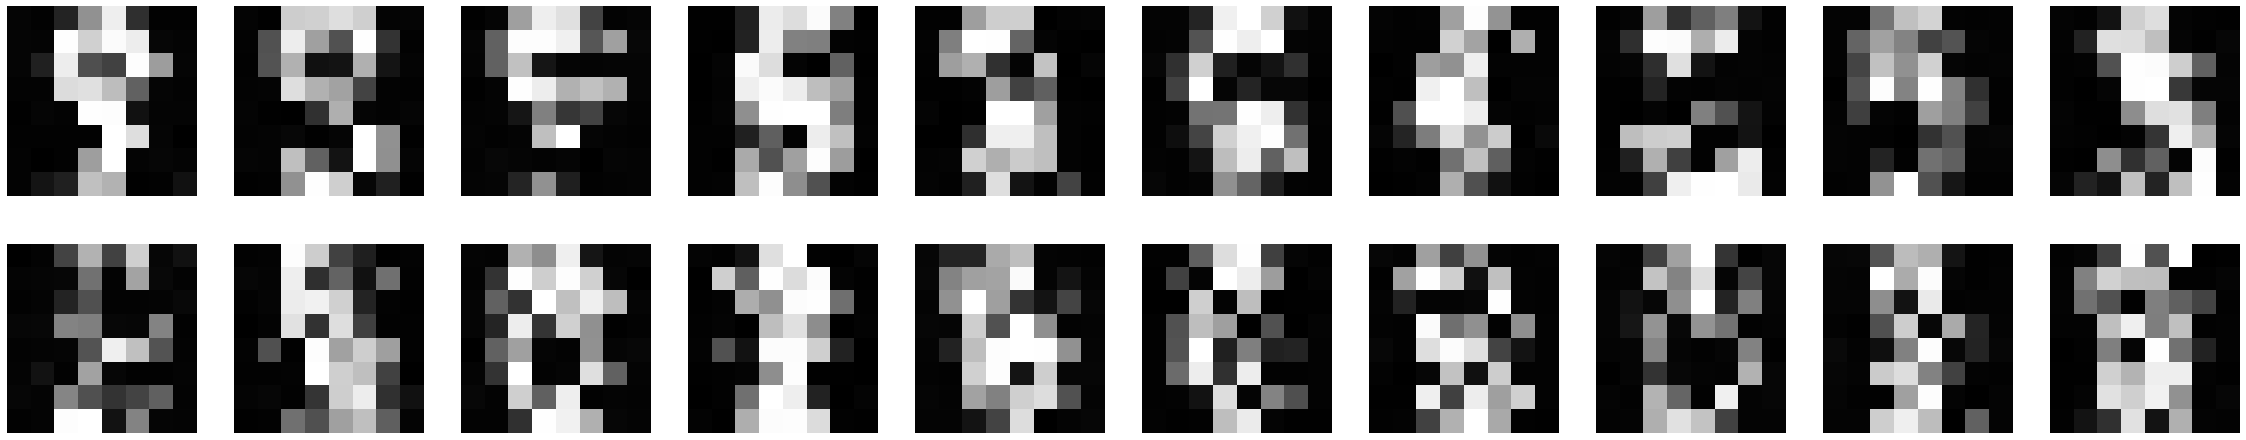

In [4]:
import matplotlib.pyplot as plt

noise_test = torch.randn(100000, 1, 8, 8)
r_noise = model(noise_test)
top_10_idx = np.argpartition(r_noise.detach().numpy().flatten(), -10)[-10:]
# Create a subplot of size 2x10
fig, axes = plt.subplots(2, 10, figsize=(40, 8))

# Plot the images corresponding to the largest 10 values in the first row
for i, idx in enumerate(top_10_idx):
    axes[0, i].matshow(reverse_transform(noise_test[idx].squeeze()), cmap='gray')
    axes[0, i].axis('off')
# Plot random images in the second row
for i, idx in enumerate(range(10)):
    axes[1, i].matshow(reverse_transform(noise_test[idx].squeeze()), cmap='gray')
    axes[1, i].axis('off')

plt.show()

In [81]:
noise_test[idx].squeeze().shape

torch.Size([8, 8])

In [5]:
# HMC

from pyhmc import hmc
import torch
import numpy as np

from tqdm import tqdm

def sample_hmc(ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        ratio_model: nn.Module - the ratio model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''

    def log_r_times_gauss(x):
        x_tensor = torch.tensor(x.reshape(1, 1, 8, 8), dtype=torch.float32, requires_grad=True)
        fun = torch.log(ratio_model(x_tensor)).sum() + torch.distributions.Normal(0, 1).log_prob(x_tensor).sum()
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 64))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 8, 8))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        x0_run = torch.randn(1, 1, 8, 8)
        samples_, log_pdf_ = hmc(log_r_times_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,64), log_pdf.reshape(-1), x0_noise

samples, log_pdf, x0_noises = sample_hmc(ratio_model=model, 
                            num_samples=1, 
                            num_runs_hmc=500,
                            num_burnin=5000)
samples.shape,log_pdf.shape,x0_noises.shape

100%|██████████| 500/500 [1:39:49<00:00, 11.98s/it]


((500, 64), (500,), (500, 8, 8))

In [13]:
samples.shape

(500, 64)

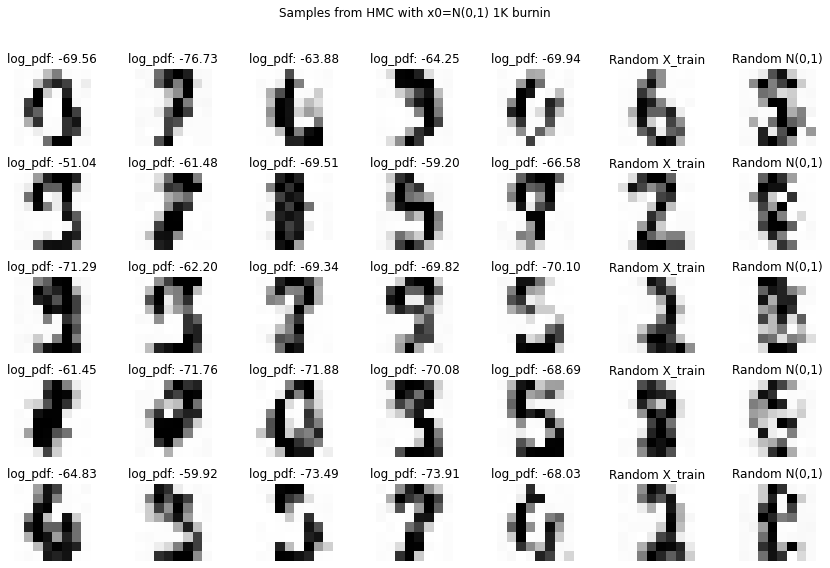

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a figure and a set of subplots
fig, axes = plt.subplots(5, 7, figsize=(12, 8))
fig.suptitle('Samples from HMC with x0=N(0,1) 1K burnin')

# Loop through each row
for row in range(5):
    # Plot the samples in the first 5 columns
    for col in range(5):
        ax = axes[row, col]
        index = row * 20 + 11*col
        img = reverse_transform(torch.tensor(samples[index]).reshape(8, 8)).reshape(8, 8)
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')
        ax.set_title(f"log_pdf: {log_pdf[index]:.2f}")

    # Plot random samples of X_train in the 6th column
    ax = axes[row, 5]
    random_index = np.random.randint(len(X_train))
    img = reverse_transform(X_train[random_index]).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random X_train")

    # Plot random samples of N(0,1) in the 7th column
    ax = axes[row, 6]
    img = reverse_transform(torch.randn(1, 1, 8, 8)).reshape(8, 8)
    ax.imshow(img, cmap='gray_r')
    ax.axis('off')
    ax.set_title("Random N(0,1)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make room for the suptitle
plt.show()

In [311]:
model.c

Parameter containing:
tensor(1.0414, requires_grad=True)

In [315]:
model(X_test).mean()

tensor(2.1032e+08, grad_fn=<MeanBackward0>)

In [299]:
model(X_test[100].unsqueeze(0)+0.01*torch.randn(1,1,8,8)).item()

277889.78125

In [8]:
def Energy_Score_pytorch(beta, observations_y, simulations_Y):
    m = len(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = torch.pow(
        torch.norm(
            (observations_y.unsqueeze(1) -
            simulations_Y.unsqueeze(0)).float(),
            dim=2,keepdim=True).reshape(-1,1),
        beta)

    # Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * torch.pow(
        nn.functional.pdist(simulations_Y),
        beta)
    Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
    return Energy

In [246]:
GG_cov = np.cov(X_train.reshape(-1,64).T)
GG_samples = scs.multivariate_normal.rvs(mean=np.zeros(64), cov=GG_cov, size=5000)

In [375]:
top = scs.multivariate_normal(mean=np.zeros(64), cov=GG_cov).logpdf(X_test.reshape(-1,64))
bottom = scs.norm.logpdf(X_test.reshape(-1,64), loc=0, scale=1).sum(1)
(top-bottom).mean()

11.74092669482379

In [377]:
model(X_test).log().mean()

tensor(10.1938, grad_fn=<MeanBackward0>)

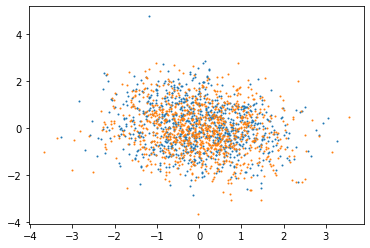

In [241]:
plt.scatter(X_train.reshape(-1,64)[:,30],X_train.reshape(-1,64)[:,1],s=1)
plt.scatter(GG_samples[:,30],GG_samples[:,1],s=1)

In [9]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.6930) samples
tensor(11.2314) random
tensor(11.2040) observations


In [329]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.8800) samples
tensor(11.2422) GG
tensor(11.2687) random
tensor(11.2403) observations


In [322]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.4530) samples
tensor(11.2422) GG
tensor(11.2690) random
tensor(11.2403) observations


In [247]:
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(samples).float()),'samples')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.tensor(GG_samples).float()),'GG')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),torch.randn(5000,64).float()),'random')
print(Energy_Score_pytorch(1,X_test.reshape(-1,64),X_train.reshape(-1,64)),'observations')

tensor(11.2689) samples
tensor(11.2675) GG
tensor(11.2947) random
tensor(11.2676) observations


### MNIST 784d

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot

# Define a classifier for MNIST images
class Classifier_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28)):
        super(Classifier_MNIST, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define model
model = Classifier_MNIST()

# Print model summary
summary(model, (1, 28, 28))

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Example input for visualization
x = torch.randn(1, 1, 28, 28)
y = model(x)

# Plot the model
make_dot(y, params=dict(model.named_parameters())).render("discriminator_plot", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                    [-1, 1]           3,137
           Sigmoid-9                    [-1, 1]               0
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
---------------------------------------------

'discriminator_plot.png'